In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2

env: CUDA_VISIBLE_DEVICES=MIG-cbafb023-40ef-594e-9092-fb0e3c44baa2


In [2]:
import io
import torch
import torch.nn as nn
import PIL.Image
import einops
import matplotlib.pyplot as plt
import numpy as np
import datasets
import math
import random
from timm.optim import Mars
from types import SimpleNamespace
from IPython.display import HTML
from types import SimpleNamespace
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop
from torchvision.transforms.v2.functional import pil_to_tensor, to_pil_image
from decord import VideoReader
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent

In [3]:
device = "cuda"
dataset = datasets.load_dataset("danjacobellis/davis").cast_column('video',datasets.Video()).with_format("torch")

In [4]:
checkpoint = torch.load('checkpoint.pth', map_location="cpu",weights_only=False)
config = checkpoint['config']
state_dict = checkpoint['state_dict']
model = AutoCodecND(
    dim=3,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)
model.load_state_dict(state_dict)
model.eval();

In [5]:
overlap = 2
stride = 5
block_size = stride + 2 * overlap
target_w = 1920
target_h = 1080
upsampling_factor = config.F
overlap_pixels = overlap * upsampling_factor  # e.g., 4 * 8 = 32
central_size_pixels = stride * upsampling_factor  # e.g., 16 * 8 = 128

def pad3d(x, p, extra, small_dim_mode):
    b, c, f, h, w = x.shape
    for dim, size in zip(['f', 'h', 'w'], [f, h, w]):
        if small_dim_mode and size < p:
            pad1 = extra
            pad2 = extra
        else:
            t = math.ceil(size / p) * p
            pad_total = t - size
            pad1 = pad_total // 2
            pad2 = pad_total - pad1
            pad1 += extra
            pad2 += extra
        if dim == 'f':
            fp1, fp2 = pad1, pad2
        elif dim == 'h':
            hp1, hp2 = pad1, pad2
        elif dim == 'w':
            wp1, wp2 = pad1, pad2
    return torch.nn.functional.pad(
        x,
        pad=(wp1, wp2, hp1, hp2, fp1, fp2),
        mode="reflect"
    )

In [ ]:
PSNR_list = []
pb = progress_bar(dataset['train'])
for sample in pb:
    video = sample['video']
    len_video = len(video)
    xr = video.get_batch(range(len_video))
    xr = einops.rearrange(xr, 'f h w c -> c f h w')
    x = []
    for i_frame in range(xr.shape[1]):
        frame = xr[:, i_frame]
        pil_img = to_pil_image(frame)
        resized_img = pil_img.resize((target_w, target_h))
        tensor_frame = pil_to_tensor(resized_img).unsqueeze(1)
        x.append(tensor_frame)
    x = torch.cat(x, dim=1).unsqueeze(0)
    x = x / 127.5 - 1.0
    x = x.to(device)
    x_orig = x.clone()
    x = pad3d(x, p=config.F*stride, extra=config.F*overlap, small_dim_mode=False)
    
    with torch.no_grad():
        z = model.encode(x)
        latent = model.quantize.compand(z).round()

    # Latent dimensions
    T_l, H_l, W_l = latent.shape[2], latent.shape[3], latent.shape[4]
    F_padded = T_l * config.F
    H_padded = H_l * config.F
    W_padded = W_l * config.F
    
    # Initialize output tensor
    x_hat = torch.zeros(1, 3, F_padded, H_padded, W_padded, device=device)
    
    # Number of blocks (ensure at least 1 block per dimension)
    num_blocks_t = max(((T_l - block_size) // stride) + 1, 1)
    num_blocks_h = max(((H_l - block_size) // stride) + 1, 1)
    num_blocks_w = max(((W_l - block_size) // stride) + 1, 1)
    
    for k_t in range(num_blocks_t):
        for k_h in range(num_blocks_h):
            for k_w in range(num_blocks_w):
                # Compute start indices (0 if only one block, else k * stride)
                start_t = k_t * stride if num_blocks_t > 1 else 0
                start_h = k_h * stride if num_blocks_h > 1 else 0
                start_w = k_w * stride if num_blocks_w > 1 else 0
                
                # Compute end indices, clamped to latent dimensions
                end_t = min(start_t + block_size, T_l)
                end_h = min(start_h + block_size, H_l)
                end_w = min(start_w + block_size, W_l)
                
                # Extract latent block
                latent_block = latent[:, :, start_t:end_t, start_h:end_h, start_w:end_w]
                
                # Compute padding needed to reach block_size
                pad_t_left = (block_size - (end_t - start_t)) // 2 if end_t - start_t < block_size else 0
                pad_t_right = block_size - (end_t - start_t) - pad_t_left if end_t - start_t < block_size else 0
                pad_h_left = (block_size - (end_h - start_h)) // 2 if end_h - start_h < block_size else 0
                pad_h_right = block_size - (end_h - start_h) - pad_h_left if end_h - start_h < block_size else 0
                pad_w_left = (block_size - (end_w - start_w)) // 2 if end_w - start_w < block_size else 0
                pad_w_right = block_size - (end_w - start_w) - pad_w_left if end_w - start_w < block_size else 0
                
                # Pad the latent block if necessary
                if any([pad_t_left, pad_t_right, pad_h_left, pad_h_right, pad_w_left, pad_w_right]):
                    latent_block = torch.nn.functional.pad(
                        latent_block,
                        pad=(pad_w_left, pad_w_right, pad_h_left, pad_h_right, pad_t_left, pad_t_right),
                        mode="reflect"
                    )
                
                # Decode the block
                with torch.no_grad():
                    x_hat_block = model.decode(latent_block).clamp(-1, 1)
                
                # Define central part and output placement
                for dim, num_blocks, start, end, pad_left in [
                    ('t', num_blocks_t, start_t, end_t, pad_t_left),
                    ('h', num_blocks_h, start_h, end_h, pad_h_left),
                    ('w', num_blocks_w, start_w, end_w, pad_w_left)
                ]:
                    if num_blocks > 1:
                        # Overlapping blocks: take central stride portion
                        start_central = overlap * upsampling_factor
                        end_central = start_central + stride * upsampling_factor
                        start_output = (start + overlap) * upsampling_factor
                        end_output = start_output + stride * upsampling_factor
                    else:
                        # Single block: take middle portion corresponding to original size
                        size = end - start  # Original size before padding
                        start_central = pad_left * upsampling_factor
                        end_central = start_central + size * upsampling_factor
                        start_output = 0
                        end_output = size * upsampling_factor
                    
                    if dim == 't':
                        t_start_central, t_end_central = start_central, end_central
                        t_pixel_start, t_pixel_end = start_output, end_output
                    elif dim == 'h':
                        h_start_central, h_end_central = start_central, end_central
                        h_pixel_start, h_pixel_end = start_output, end_output
                    elif dim == 'w':
                        w_start_central, w_end_central = start_central, end_central
                        w_pixel_start, w_pixel_end = start_output, end_output
                
                # Extract central part and place in output
                central_part = x_hat_block[:, :,
                                           t_start_central:t_end_central,
                                           h_start_central:h_end_central,
                                           w_start_central:w_end_central]
                x_hat[:, :,
                      t_pixel_start:t_pixel_end,
                      h_pixel_start:h_pixel_end,
                      w_pixel_start:w_pixel_end] = central_part
    
    # Crop to original dimensions
    f_start = (F_padded - len_video) // 2
    h_start = (H_padded - target_h) // 2
    w_start = (W_padded - target_w) // 2
    x_hat = x_hat[:, :,
                  f_start:f_start + len_video,
                  h_start:h_start + target_h,
                  w_start:w_start + target_w]
    x_hat = x_hat.clamp(-1, 1)
    

    x_orig_01 = x_orig / 2 + 0.5
    x_hat_01 = x_hat / 2 + 0.5
    PSNR = []
    for i_frame in range(x_orig_01.shape[2]):
        mse = torch.nn.functional.mse_loss(x_orig_01[0, :, i_frame], x_hat_01[0, :, i_frame])
        PSNR.append(-10 * mse.log10().item())
    PSNR_list.append(PSNR)

    pb.comment = (f"PSNR: {np.mean(PSNR)}")

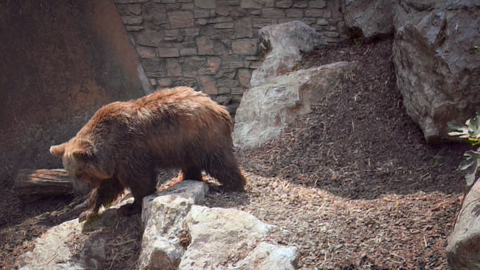

In [60]:
to_pil_image(x_hat[0,:,-1]/2+0.5).resize((1920//4,1080//4))